<a href="https://colab.research.google.com/github/luanakwon/ML_Pytorch_pre2022/blob/main/RNN_PR3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

very first try of RNN.

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import string
import random
import matplotlib.pyplot as plt

In [ ]:
######### hyper #########
epoch = 700
lr = 0.001

embedding_size = 70
hidden_size = 80
num_layers = 3

chunk_len = 300

In [ ]:
chars = string.printable
print(chars[0])

file_path = 'drive/MyDrive/text_dataset/Headlights.txt'
FILE = str(open(file_path).read())
#FILE = FILE.lower()
print(FILE[:chunk_len*5])

FILE = FILE.replace(' ',chars[98])
for c in chars[62:98]:
  FILE = FILE.replace(c,chars[98]+c+chars[98])
FILE = FILE.replace(chars[98]+chars[98],chars[98])
FILE = FILE.split(chars[98])

i_to_v = list(set(FILE))
v_to_i = {s:i for i, s in enumerate(i_to_v)}
vocab_len = len(i_to_v)

for i,s in enumerate(FILE):
  FILE[i] = v_to_i[s]

file_len = len(FILE)
print(len(i_to_v))

0
Mom, I know I let you down
And though you say the days are happy
Why is the power off and I'm fucked up?
And, mom, I know he's not around
But don't you place the blame on me
As you pour yourself another drink, yeah
I guess we are who we are
Headlights shining in the dark night, I drive on
Maybe we took this too far
I went in headfirst, never thinkin' about who, what I said hurt
In what verse, my mom probably got it the worst
The brunt of it, but as stubborn as we are, did I take it too far?
"Cleanin' Out My Closet" and all them other songs
But regardless, I don't hate you 'cause, Ma
You're still beautiful to me, 'cause you're my Ma
Though far be it from you to be calm
Our house was Vietnam, Desert Storm
And both of us put together could form an atomic bomb
Equivalent to chemical warfare
And forever we could drag this on and on
But agree to disagree, that gift for me
Up under the Christmas tree don't mean shit to me
You're kickin' me out? It's 15 degrees
And it's Christmas Eve, "Littl

In [ ]:
def random_chunk():
  start_idx = random.randint(0,file_len-chunk_len-1)
  end_idx = start_idx + chunk_len
  return FILE[start_idx:end_idx]
  #return FILE[0:chunk_len]

def idx2word(index):
  return i_to_v[index]

def word2idx(word):
  return v_to_i[word]

print(word2idx('I'))

128


In [ ]:
class RNN(nn.Module):
  def __init__(self,vocab_len,embedding_size,hidden_size,num_layers):
    super(RNN,self).__init__()

    self.hidden_size = hidden_size
    self.num_layers = num_layers

    # input : batch,seq
    self.embedding_layer = nn.Embedding(vocab_len,embedding_size) 
    # output : batch, seq, dim
    # input : batch, seq, dim
    # hidden : batch, layer*dir, hid_dim
    self.rnn_layer = nn.RNN(embedding_size,hidden_size,num_layers,batch_first=True,)
    # output : batch, seq, dir*hid_dim
    # input : batch, seq, dir*hid_dim
    self.translate_layer = nn.Linear(hidden_size,embedding_size)
    # output : batch, seq, embedding_dim
    # input : batch, seq, embedding_dim 
    self.decoding_layer = nn.Sequential(
        nn.Linear(embedding_size,vocab_len)
    )
    # output = batch, seq, vocab_len

  def forward(self,input_,hidden, batch_size):
    out = self.embedding_layer(input_.view(batch_size,-1))
    seq_len = out.shape[1]
    out, hidden = self.rnn_layer(out,hidden)
    out = out.view(batch_size, seq_len, -1)
    out = self.translate_layer(out)
    out = self.decoding_layer(out)
    return out, hidden

  def init_hidden(self, batch_size):
    return torch.zeros(self.num_layers,batch_size, self.hidden_size)

In [ ]:
rnn = RNN(vocab_len,embedding_size,hidden_size,num_layers)

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn.parameters(),lr=lr)
#optimizer = torch.optim.SGD(rnn.parameters(),lr=lr)

In [ ]:
loss = []

for e in range(epoch):
  optimizer.zero_grad()

  chunk = random_chunk()
  inp = torch.LongTensor(chunk[:-1])
  # label = np.zeros((1,chunk_len-1,vocab_len))
  # for i, idx in enumerate(chunk[1:]):
  #   label[0,i,idx] = 1
  # label = torch.Tensor(label)
  label = torch.LongTensor(chunk[1:])
  hidden = rnn.init_hidden(1)

  total_loss = 0

  out, hidden = rnn.forward(inp,hidden,batch_size=1)
  total_loss = loss_func(out.view(1*(chunk_len-1),-1), label)


  # for i in range(chunk_len-1):
    
  #   out, hidden = rnn.forward(inp[i],hidden)
  #   total_loss += loss_func(out,label[i].view(-1))
    
  loss.append(total_loss.data)  
  total_loss.backward()
  optimizer.step()
  
  if e%10==0:
    print('\r epoch %d loss %f '%(e,total_loss.data),end='')

 epoch 690 loss 0.021837 

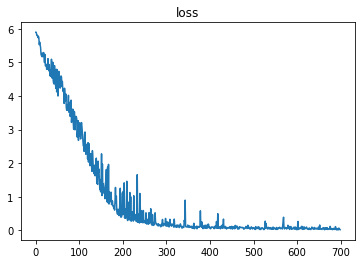

In [ ]:
plt.title('loss')
plt.plot(loss)
plt.show()

In [ ]:
with torch.no_grad():
  start_tok = 'for'
  s = start_tok + ' '
  hidden = rnn.init_hidden(1)
  inp = torch.LongTensor([word2idx(start_tok)]).view(1,1)
  for i in range(1000):
    #print(inp.data)
    out, hidden = rnn.forward(inp,hidden,batch_size=1)
    idx = np.argmax(out.view(-1).numpy())
    s += idx2word(idx) + ' '
    inp = torch.LongTensor([idx]).view(1,1)

  print(s)

for " Cleanin ' Out My Closet " 
 At the time I was angry , rightfully ? Maybe so 
 Never meant that far to take it though 
 ' Cause now I know it ' s not your fault , and I ' m not makin ' jokes 
 That song I no longer play at shows 
 And I cringe every time it ' s on the radio 
 And I think of Nathan being placed in a home 
 And all the medicine you fed us and 
 How I just wanted you to taste your own 
 But now the medication ' s takin ' over 
 And your mental state ' s deterioratin ' slow 
 And I ' m way too old to cry , the shit is painful though 
 But , Ma , I forgive you , so does Nathan , yo 
 All you did , all you said , you did your best to raise us both 
 Foster care , that cross you bear , few may be as heavy as yours 
 But I love you , Debbie Mathers 
 Oh , what a tangled web we have ' cause 
 One thing I never asked was 
 Where the fuck my deadbeat dad was 
 Fuck it , I guess he had trouble keepin ' up with every address 
 But I ' da flipped every mattress , every rock and